The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Previsão de Preços de Imóveis no Kaggle
:label:`sec_kaggle_house`


Agora que apresentamos algumas ferramentas básicas
para construir e treinar redes profundas
e regularizá-las com técnicas, incluindo
queda de peso e abandono,
estamos prontos para colocar todo esse conhecimento em prática
participando de uma competição *Kaggle*.
A competição de previsão de preços de casas
é um ótimo lugar para começar.
Os dados são bastante genéricos e não exibem uma estrutura exótica
que podem exigir modelos especializados (como áudio ou vídeo).
Este conjunto de dados, coletado por Bart de Cock em 2011 :cite:`De-Cock.2011`,
cobre os preços da habitação em Ames, IA do período de 2006-2010.
É consideravelmente maior do que o famoso [conjunto de dados de habitação de Boston](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names) de Harrison e Rubinfeld (1978),
ostentando mais exemplos e mais recursos.


Nesta seção, iremos orientá-lo nos detalhes de
pré-processamento de dados, design de modelo e seleção de hiperparâmetros.
Esperamos que, por meio de uma abordagem prática,
você ganhe algumas intuições que irão guiá-lo
em sua carreira como cientista de dados.


## *Download* e *Cache* de *datasets*
Ao longo do livro, treinaremos e testaremos modelos
em vários conjuntos de dados baixados.
Aqui, implementamos várias funções utilitárias
para facilitar o *download* de dados.
Primeiro, mantemos um dicionário `DATA_HUB`
que mapeia uma string (o *nome* do conjunto de dados)
a uma tupla contendo o URL para localizar o conjunto de dados
e a chave SHA-1 que verifica a integridade do arquivo.
Todos esses conjuntos de dados são hospedados no site
cujo endereço é `DATA_URL`.


In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

A seguinte função `download` baixa um conjunto de dados,
armazenando em cache em um diretório local (`../data` por padrão)
e retorna o nome do arquivo baixado.
Se um arquivo correspondente a este conjunto de dados
já existe no diretório de cache
e seu SHA-1 corresponde ao armazenado em `DATA_HUB`,
nosso código usará o arquivo em cache para evitar
obstruir sua internet com *downloads* redundantes.


In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

Também implementamos duas funções utilitárias adicionais:
uma é baixar e extrair um arquivo zip ou tar
e o outro para baixar todos os conjuntos de dados usados neste livro de `DATA_HUB` para o diretório de cache.


In [3]:
def download_extract(name, folder=None):  #@save
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

## *Kaggle*

[Kaggle](https://www.kaggle.com) é uma plataforma popular
que hospeda competições de *machine learning*.
Cada competição se concentra em um conjunto de dados e muitos
são patrocinados por interessados que oferecem prêmios
para as soluções vencedoras.
A plataforma ajuda os usuários a interagir
por meio de fóruns e código compartilhado,
fomentando a colaboração e a competição.
Embora a perseguição ao placar muitas vezes saia do controle,
com pesquisadores focando miopicamente nas etapas de pré-processamento
em vez de fazer perguntas fundamentais,
também há um enorme valor na objetividade de uma plataforma
que facilita comparações quantitativas diretas
entre abordagens concorrentes, bem como compartilhamento de código
para que todos possam aprender o que funcionou e o que não funcionou.
Se você quiser participar de uma competição *Kaggle*,
primeiro você precisa se registrar para uma conta
(veja :numref:`fig_kaggle`).

![Site do Kaggle.](../img/kaggle.png)
:width:`400px`
:label:`fig_kaggle`

Na página de competição de previsão de preços de casas, conforme ilustrado
em :numref:`fig_house_pricing`,
você pode encontrar o conjunto de dados (na guia "Dados"),
enviar previsões e ver sua classificação,
A URL está bem aqui:

> https://www.kaggle.com/c/house-prices-advanced-regression-techniques

![A página da competição de previsão de preços de casas.](../img/house-pricing.png)
:width:`400px`
:label:`fig_house_pricing`

## Acessando e Lendo o Conjunto de Dados


Observe que os dados da competição são separados
em conjuntos de treinamento e teste.
Cada registro inclui o valor da propriedade da casa
e atributos como tipo de rua, ano de construção,
tipo de telhado, condição do porão, etc.
Os recursos consistem em vários tipos de dados.
Por exemplo, o ano de construção
é representado por um número inteiro,
o tipo de telhado por atribuições categóricas discretas,
e outros recursos por números de ponto flutuante.
E é aqui que a realidade complica as coisas:
para alguns exemplos, alguns dados estão ausentes
com o valor ausente marcado simplesmente como "na".
O preço de cada casa está incluído
para o conjunto de treinamento apenas
(afinal, é uma competição).
Queremos particionar o conjunto de treinamento
para criar um conjunto de validação,
mas só podemos avaliar nossos modelos no conjunto de teste oficial
depois de enviar previsões para Kaggle.
A guia "Dados" na guia da competição
em :numref:`fig_house_pricing`
tem links para baixar os dados.


Para começar, vamos ler e processar os dados
usando `pandas`, que introduzimos em :numref:`sec_pandas`.
Então, você vai querer ter certeza de que instalou o `pandas`
antes de prosseguir.
Felizmente, se você estiver no Jupyter,
podemos instalar pandas sem nem mesmo sair do notebook.


In [4]:
# If pandas is not installed, please uncomment the following line:
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

Por conveniência, podemos baixar e armazenar em cache
o conjunto de dados de habitação *Kaggle*
usando o *script* que definimos acima.


In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

Usamos `pandas` para carregar os dois arquivos csv contendo dados de treinamento e teste, respectivamente.


In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

O conjunto de dados de treinamento inclui 1460 exemplos,
80 características e 1 rótulo, enquanto os dados de teste
contém 1459 exemplos e 80 características.


In [7]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


Vamos dar uma olhada nos primeiros quatro e nos dois últimos recursos
bem como o rótulo (SalePrice) dos primeiros quatro exemplos.


In [8]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


Podemos ver que em cada exemplo, a primeira característica é o ID.
Isso ajuda o modelo a identificar cada exemplo de treinamento.
Embora seja conveniente, ele não carrega
qualquer informação para fins de previsão.
Portanto, nós o removemos do conjunto de dados
antes de alimentar os dados no modelo.


In [9]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## Pré-processamento de Dados

Conforme declarado acima, temos uma grande variedade de tipos de dados.
Precisaremos pré-processar os dados antes de começarmos a modelagem.
Vamos começar com as *features* numéricas.
Primeiro, aplicamos uma heurística,
substituindo todos os valores ausentes
pela média da feature correspondente.
Então, para colocar todos os recursos em uma escala comum,
nós *padronizamos* os dados
redimensionando recursos para média zero e variancia unitária:

$$x \leftarrow \frac{x - \mu}{\sigma},$$

onde $\mu$ e $\sigma$ denotam média e desvio padrão, respectivamente.
Para verificar se isso realmente transforma
nossa *feature* (variável) de modo que tenha média zero e variância unitária,
observe que $E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{\sigma} = 0$
e que $E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2$.
Intuitivamente, padronizamos os dados
por duas razões.
Primeiro, se mostra conveniente para otimização.
Em segundo lugar, porque não sabemos *a priori*
quais *features* serão relevantes,
não queremos penalizar coeficientes
atribuídos a uma *feature* mais do que a qualquer outra.


In [10]:
# If test data were inaccessible, mean and standard deviation could be
# calculated from training data
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

Em seguida, lidamos com valores discretos.
Isso inclui recursos como "MSZoning".
Nós os substituímos por uma codificação one-hot
da mesma forma que transformamos anteriormente
rótulos multiclasse em vetores (veja :numref:`subsec_classification-problem`).
Por exemplo, "MSZoning" assume os valores "RL" e "RM".
Eliminando a *feature* "MSZoning",
duas novas *features* de indicador
"MSZoning_RL" e "MSZoning_RM" são criadas com valores 0 ou 1.
De acordo com a codificação one-hot,
se o valor original de "MSZoning" for "RL",
então "MSZoning_RL" é 1 e "MSZoning_RM" é 0.
O pacote `pandas` faz isso automaticamente para nós.


In [11]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

Você pode ver que essa conversão aumenta
o número de *features* de 79 a 331.
Finalmente, por meio do atributo `values`,
podemos extrair o formato NumPy do formato `pandas`
e convertê-lo no tensor
representação para treinamento.


In [12]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

## Treinamento

Para começar, treinamos um modelo linear com perda quadrática.
Não surpreendentemente, nosso modelo linear não conduzirá
para uma inscrição vencedora de competição
mas fornece uma verificação de sanidade para ver se
há informações significativas nos dados.
Se não podemos fazer melhor do que adivinhação aleatória aqui,
então pode haver uma boa chance
que temos um bug de processamento de dados.
E se as coisas funcionarem, o modelo linear servirá como base
dando-nos alguma intuição sobre o quão próximo o modelo simples
chega aos melhores modelos relatados, dando-nos uma ideia
de quanto ganho devemos esperar de modelos mais sofisticados.


In [13]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

Com os preços das casas, assim como com os preços das ações,
nós nos preocupamos com as quantidades relativas
mais do que quantidades absolutas.
Assim, tendemos a nos preocupar mais com
o erro relativo $\frac{y - \hat{y}}{y}$
do que sobre o erro absoluto $y - \hat{y}$.
Por exemplo, se nossa previsão estiver errada em US $ 100.000
ao estimar o preço de uma casa na zona rural de Ohio,
onde o valor de uma casa típica é 125.000 USD,
então provavelmente estamos fazendo um trabalho horrível.
Por outro lado, se errarmos neste valor
em Los Altos Hills, Califórnia,
isso pode representar uma previsão incrivelmente precisa
(lá, o preço médio da casa excede 4 milhões de dólares).

Uma maneira de resolver este problema é
medir a discrepância no logaritmo das estimativas de preços.
Na verdade, esta é também a medida de erro oficial
usado pela competição para avaliar a qualidade dos envios.
Afinal, um pequeno valor $\delta$ for $|\log y - \log \hat{y}| \leq \delta$
se traduz em $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$.
Isso leva ao seguinte erro de raiz quadrada média entre o logaritmo do preço previsto e o logaritmo do preço do rótulo:

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


In [14]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

Ao contrário das seções anteriores, nossas funções de treinamento
contarão com o otimizador Adam
(iremos descrevê-lo em maiores detalhes posteriormente).
O principal apelo deste otimizador é que,
apesar de não melhorar (e às vezes piorar)
dados recursos ilimitados para otimização de hiperparâmetros,
as pessoas tendem a achar que é significativamente menos sensível
à taxa de aprendizagem inicial.


In [15]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## Validação Cruzada $K$-Fold

Você deve se lembrar que introduzimos validação cruzada $K$-fold
na seção onde discutimos como lidar
com seleção de modelo (:numref:`sec_model_selection`).
Faremos um bom uso disso para selecionar o design do modelo
e ajustar os hiperparâmetros.
Primeiro precisamos de uma função que retorna
a $i^\mathrm{th}$ dobra dos dados
em um procedimento de validação cruzada $K$-fold.
Ela continua cortando o segmento $i^\mathrm{th}$
como dados de validação e retornando o resto como dados de treinamento.
Observe que esta não é a maneira mais eficiente de lidar com dados
e definitivamente faríamos algo muito mais inteligente
se nosso conjunto de dados fosse consideravelmente maior.
Mas essa complexidade adicional pode ofuscar nosso código desnecessariamente
portanto, podemos omiti-lo com segurança devido à simplicidade do nosso problema.


In [16]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

As médias de erro de treinamento e verificação são retornadas
quando treinamos $K$ vezes na validação cruzada de $K$.


In [17]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## Seleção de Modelo

Neste exemplo, escolhemos um conjunto desafinado de hiperparâmetros
e deixamos para o leitor melhorar o modelo.
Encontrar uma boa escolha pode levar tempo,
dependendo de quantas variáveis alguém otimiza.
Com um conjunto de dados grande o suficiente,
e os tipos normais de hiperparâmetros,
Validação cruzada $K$-fold tende a ser
razoavelmente resiliente contra vários testes.
No entanto, se tentarmos um número excessivamente grande de opções
podemos apenas ter sorte e descobrir que nossa validação
o desempenho não é mais representativo do verdadeiro erro.


fold 1, train log rmse 0.170435, valid log rmse 0.157006


fold 2, train log rmse 0.162808, valid log rmse 0.192237


fold 3, train log rmse 0.163597, valid log rmse 0.168006


fold 4, train log rmse 0.168409, valid log rmse 0.154589


fold 5, train log rmse 0.163689, valid log rmse 0.183117
5-fold validation: avg train log rmse: 0.165788, avg valid log rmse: 0.170991


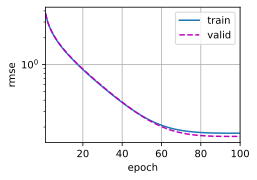

In [18]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

Observe que às vezes o número de erros de treinamento
para um conjunto de hiperparâmetros pode ser muito baixo,
mesmo com o número de erros na validação cruzada de $K$-fold
consideravelmente maior.
Isso indica que estamos com *overfitting*.
Durante o treinamento, você desejará monitorar os dois números.
Menos *overfitting* pode indicar que nossos dados podem suportar um modelo mais poderoso.
O *verfitting* maciço pode sugerir que podemos ganhar
incorporando técnicas de regularização.

##  Enviando Previsões no Kaggle

Agora que sabemos qual deve ser uma boa escolha de hiperparâmetros,
podemos também usar todos os dados para treinar nele
(em vez de apenas $1-1/K$ dos dados
que são usados nas fatias de validação cruzada).
O modelo que obtemos desta forma
pode então ser aplicado ao conjunto de teste.
Salvar as previsões em um arquivo csv
irá simplificar o upload dos resultados para o Kaggle.


In [19]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = net(test_features).detach().numpy()
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

Uma boa verificação de sanidade é ver
se as previsões no conjunto de teste
assemelham-se aos do processo de validação cruzada $K$-fold.
Se o fizerem, é hora de enviá-los para o Kaggle.
O código a seguir irá gerar um arquivo chamado `submit.csv`.


train log rmse 0.162520


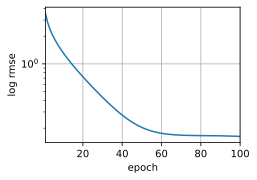

In [20]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

A seguir, conforme demonstrado em:numref:`fig_kaggle_submit2`,
podemos enviar nossas previsões no Kaggle
e veja como elas se comparam aos preços reais das casas (rótulos)
no conjunto de teste.
As etapas são bastante simples:

* Faça login no site do Kaggle e visite a página de competição de previsão de preços de casas.
* Clique no botão “Enviar previsões” ou “Envio tardio” (no momento da redação deste botão, o botão está localizado à direita).
* Clique no botão “Enviar arquivo de envio” na caixa tracejada na parte inferior da página e selecione o arquivo de previsão que deseja enviar.
* Clique no botão “Fazer envio” na parte inferior da página para ver seus resultados.
* 
![Enviando dados para o Kaggle](../img/kaggle-submit2.png)
:width:`400px`
:label:`fig_kaggle_submit2`

## Resumo

* Os dados reais geralmente contêm uma combinação de diferentes tipos de dados e precisam ser pré-processados.
* Redimensionar dados de valor real para média zero e variância unitária é um bom padrão. O mesmo ocorre com a substituição dos valores ausentes por sua média.
* Transformar características categóricas em características de indicadores nos permite tratá-las como vetores únicos.
* Podemos usar a validação cruzada de $K$ para selecionar o modelo e ajustar os hiperparâmetros.
* Os logaritmos são úteis para erros relativos.


## Exercícios

1. Envie suas previsões para esta seção para o Kaggle. Quão boas são suas previsões?
1. Você pode melhorar seu modelo minimizando o logaritmo dos preços diretamente? O que acontece se você tentar prever o logaritmo do preço em vez do preço?
1. É sempre uma boa ideia substituir os valores ausentes por sua média? Dica: você pode construir uma situação em que os valores não faltem aleatoriamente?
1. Melhore a pontuação no Kaggle ajustando os hiperparâmetros por meio da validação cruzada de $K$.
1. Melhore a pontuação melhorando o modelo (por exemplo, camadas, *weight decay* e eliminação).
1. O que acontece se não padronizarmos as características numéricas contínuas como fizemos nesta seção?


[Discussions](https://discuss.d2l.ai/t/107)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTEyMTg4MDM1OTQsMTMwMzYyMzg3MSwyMD
E3OTM4MzY1LC01NDMxMDYxODcsMjEzOTc5ODY1MCwyMjExNjM4
ODVdfQ==
-->
